<a href="https://colab.research.google.com/github/trovatore/covid/blob/master/Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
import pandas as pd
import numpy as np
import sys
import io
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
# sys.version


In [0]:
def date_to_ordinal(date):
  return datetime.strptime(date, '%Y-%m-%d').toordinal()

def dates_to_elapsed_days(dates, zero_date):
  zero_ordinal = date_to_ordinal(zero_date)
  return np.array([date_to_ordinal(date) - zero_ordinal for date in dates])

def find_fips_for_county(data, county, state):
  records = data.to_dict(orient='records')
  for record in records:
    if record['county'] == county and record['state'] == state:
      return int(record['fips'])

def find_fips_for_state(data, state):
  records = data.to_dict(orient='records')
  for record in records:
    if record['state'] == state:
      return int(record['fips'])


In [0]:
def _do_regression(elapsed_days, data_for_place, mask, ax, color, value_name):
  x = elapsed_days[mask].reshape(-1, 1)
  y = data_for_place[value_name].values[mask].reshape(-1, 1)
  lr = LinearRegression()
  lr.fit(x, np.log2(y))
  y_pred = lr.predict(x)
  ax.plot(x, np.exp(np.log(2) * y_pred), color + "-")
  return 1./lr.coef_[0][0]


In [0]:
regression_num_days = 5  #@param


In [0]:
def plot_place(data_for_place, title, lockdown_date, regression_interval=None):
  """
  Args:
    data_for_place: DataSeries with data for the particular place.
    title: Title for the plot.
    lockdown_date: YYYY-MM-DD string with date of shelter-in-place order.
    regression_interval: List of two dates giving the interval to run
      linear regression.
  """
  fig = plt.figure(figsize=(15, 10))
  ax = fig.add_subplot(111)
  elapsed_days = dates_to_elapsed_days(data_for_place['date'], lockdown_date)
  line_cases = plt.plot(elapsed_days, data_for_place['cases'], 'bo')
  line_deaths = plt.plot(elapsed_days, data_for_place['deaths'], 'ro')

  if regression_interval is None:
    end_date = max(data_for_place['date'])
    start_date = (datetime.strptime(end_date, '%Y-%m-%d')
                 - timedelta(
                     days=regression_num_days - 1)).strftime('%Y-%m-%d')
    regression_interval = [start_date, end_date]

  title = ( 
      title + " (curve fit from " + regression_interval[0] + " to " +
      regression_interval[1] + ")"
  )
  regression_interval = dates_to_elapsed_days(regression_interval,
                                              lockdown_date)
  start_day = regression_interval[0]
  end_day = regression_interval[1]
  mask = (elapsed_days >= start_day) & (elapsed_days <= end_day)
  cases_doubling_time = _do_regression(elapsed_days, data_for_place, mask,
                                        ax, 'b', 'cases' )
  deaths_doubling_time = _do_regression(elapsed_days, data_for_place, mask,
                                        ax, 'r', 'deaths' )
    
  ax.set_ylabel('log scale')
  ax.set_xlabel('days since shelter-in-place')
  ax.set_yscale('log')
  ax.yaxis.set_major_formatter(ScalarFormatter())
  ax.set_title(title)
  if regression_interval is not None:
    cases_label = 'cases (doubling time={:0.1f} days)'.format(cases_doubling_time)
    deaths_label = 'deaths (doubling time={:0.1f} days)'.format(deaths_doubling_time)
  else:
    cases_label = 'cases'
    deaths_label = 'deaths'
  cases_patch = mpatches.Patch(color='blue', label=cases_label)
  deaths_patch = mpatches.Patch(color='red', label=deaths_label)
  ax.legend(handles=[cases_patch, deaths_patch])
  plt.grid()  

In [0]:
def plot_daily_new(data_for_place, title, lockdown_date):
  """
  Args:
    data_for_place: DataSeries with data for the particular place.
    title: Title for the plot.
    lockdown_date: YYYY-MM-DD string with date of shelter-in-place order.
    regression_interval: List of two dates giving the interval to run
      linear regression.
  """
  fig = plt.figure(figsize=(15, 10))
  ax = fig.add_subplot(111)
  elapsed_days = dates_to_elapsed_days(data_for_place['date'], lockdown_date)
  assert (elapsed_days == sorted(elapsed_days)).all()
  assert elapsed_days[-1] - elapsed_days[0] + 1 == len(elapsed_days)
  line_cases = plt.plot(
      elapsed_days, np.diff(data_for_place['cases'], prepend=0), 'bo')
  line_deaths = plt.plot(
      elapsed_days, np.diff(data_for_place['deaths'], prepend=0), 'ro')
    
  ax.set_ylabel('log scale')
  ax.set_xlabel('days since shelter-in-place')
  ax.set_yscale('log')
  ax.yaxis.set_major_formatter(ScalarFormatter())
  ax.set_title(title)
  cases_label = 'New cases'
  deaths_label = 'New deaths'
  cases_patch = mpatches.Patch(color='blue', label=cases_label)
  deaths_patch = mpatches.Patch(color='red', label=deaths_label)
  ax.legend(handles=[cases_patch, deaths_patch])
  plt.grid()  

In [0]:
def plot_new_versus_cumulative(data_for_place, title, lockdown_date):
  """
  Args:
    data_for_place: DataSeries with data for the particular place.
    title: Title for the plot.
    lockdown_date: YYYY-MM-DD string with date of shelter-in-place order.
    regression_interval: List of two dates giving the interval to run
      linear regression.
  """
  fig = plt.figure(figsize=(15, 10))
  ax = fig.add_subplot(111)
  cases = data_for_place['cases']
  deaths = data_for_place['deaths']
  line_cases = plt.plot(
      cases, np.diff(data_for_place['cases'], prepend=0), 'bo')
  line_deaths = plt.plot(
      deaths, np.diff(data_for_place['deaths'], prepend=0), 'ro')
    
  ax.set_ylabel('new')
  ax.set_xlabel('cumulative')
  ax.set_yscale('log')
  ax.set_xscale('log')
  ax.yaxis.set_major_formatter(ScalarFormatter())
  ax.set_title(title)
  cases_label = 'cases'
  deaths_label = 'deaths'
  cases_patch = mpatches.Patch(color='blue', label=cases_label)
  deaths_patch = mpatches.Patch(color='red', label=deaths_label)
  ax.legend(handles=[cases_patch, deaths_patch])
  ax.set_aspect('equal')
  plt.grid()  

In [0]:
def plot_county(data, county, state, lockdown_date,
                regression_interval=None):
  fips = find_fips_for_county(data, county, state)
  data_county = data[data['fips']==fips]
  title = (
      '{} County, {}'.format(data_county['county'].tolist()[0],
                             data_county['state'].tolist()[0])
  )
  plot_place(data_county, title, lockdown_date, regression_interval)
  plot_daily_new(data_county, title, lockdown_date)
  plot_new_versus_cumulative(data_county, title, lockdown_date)


In [0]:
def plot_state(data, state, lockdown_date,
               regression_interval=None):
  fips = find_fips_for_state(data, state)
  data_state = data[data['fips']==fips]
  title = 'State of {}'.format(data_state['state'].tolist()[0])
  plot_place(data_state, title, lockdown_date, regression_interval)
  plot_daily_new(data_state, title, lockdown_date)
  plot_new_versus_cumulative(data_state, title, lockdown_date)

**Upload files**
Download `us-states.csv` and `us-counties.csv` from https://github.com/nytimes/covid-19-data and upload them here.

In [10]:
dbfile = files.upload()

Saving us-states.csv to us-states.csv
Saving us-counties.csv to us-counties.csv


In [0]:
us_counties_csv = None
us_states_csv = None
counties_name = 'us-counties.csv'
if counties_name in dbfile.keys():
  us_counties_csv = dbfile[counties_name].decode('utf-8')
states_name = 'us-states.csv'
if states_name in dbfile.keys():
  us_states_csv = dbfile[states_name].decode('utf-8')

In [0]:
data_counties = None
if us_counties_csv:
  data_counties = pd.read_csv(io.StringIO(us_counties_csv))
data_states = None
if us_states_csv:
  data_states = pd.read_csv(io.StringIO(us_states_csv))

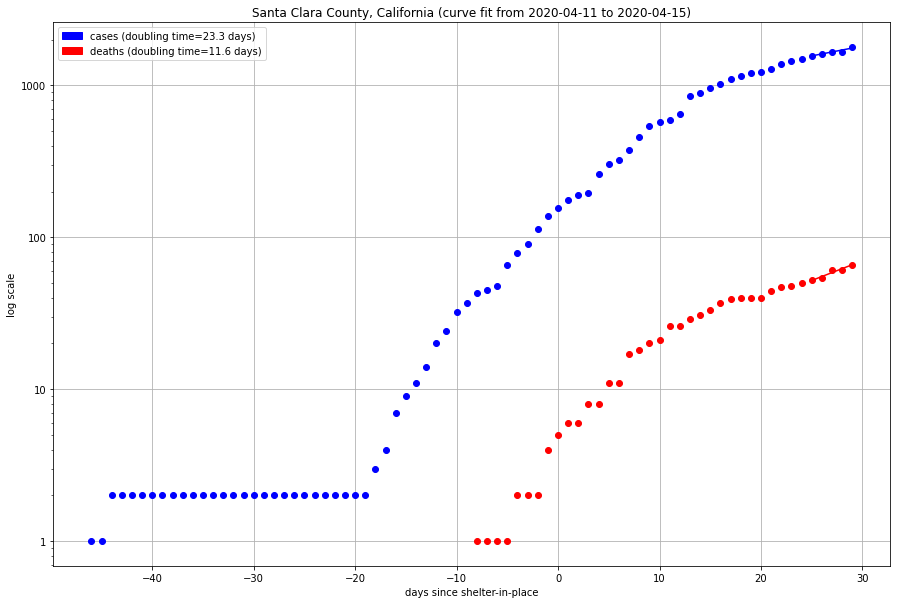

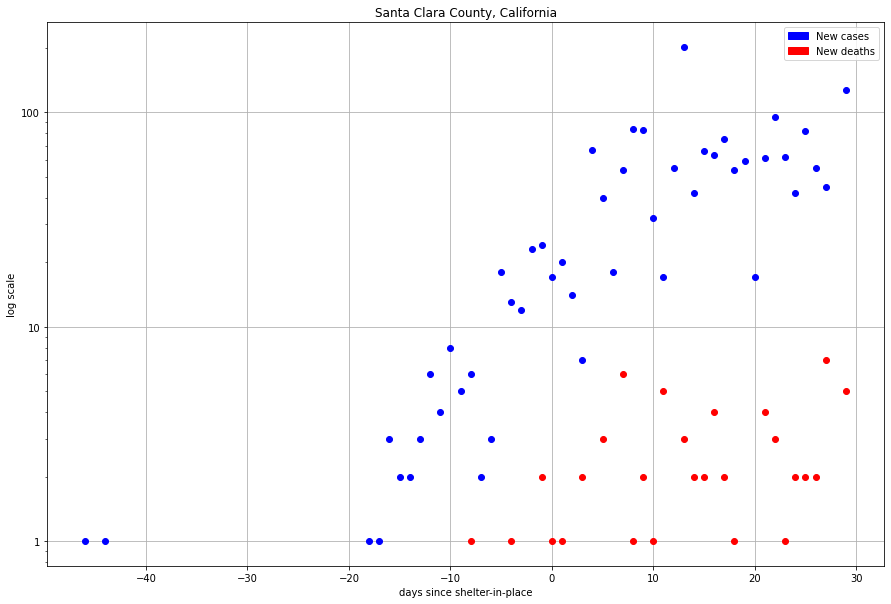

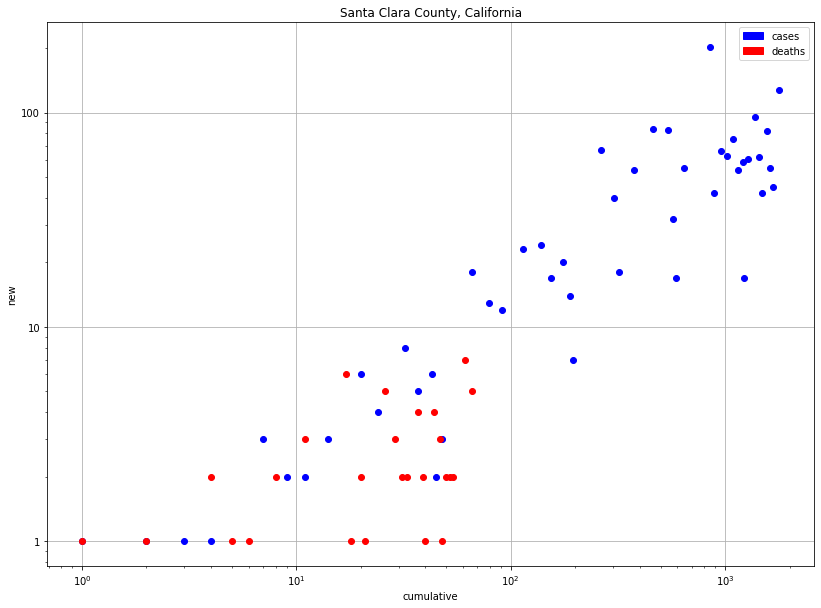

In [27]:
plot_county(data_counties, 'Santa Clara', 'California', '2020-03-17')

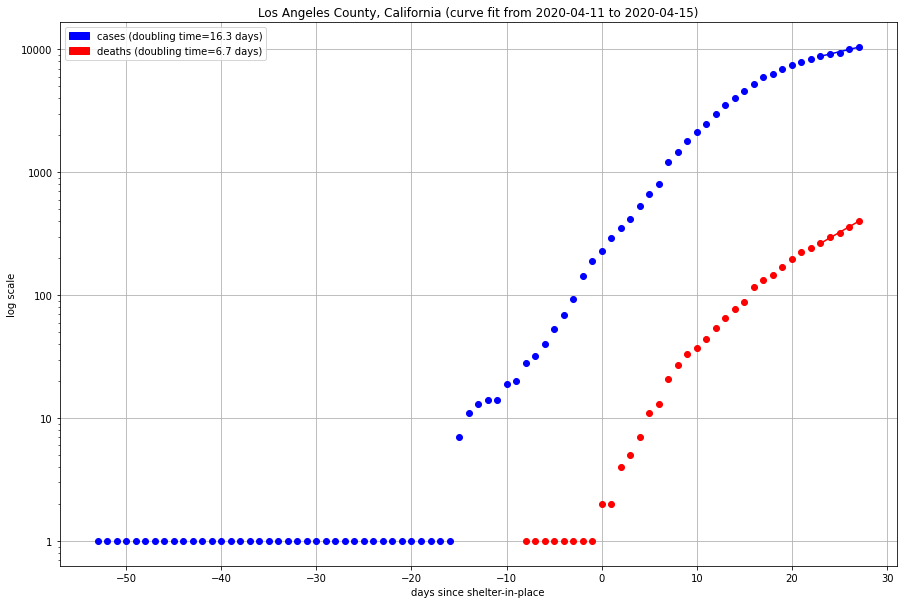

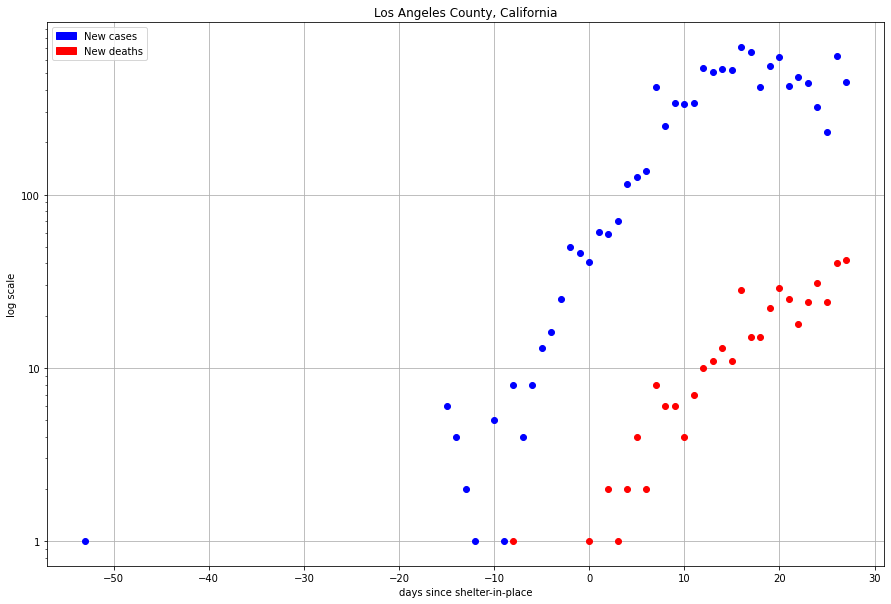

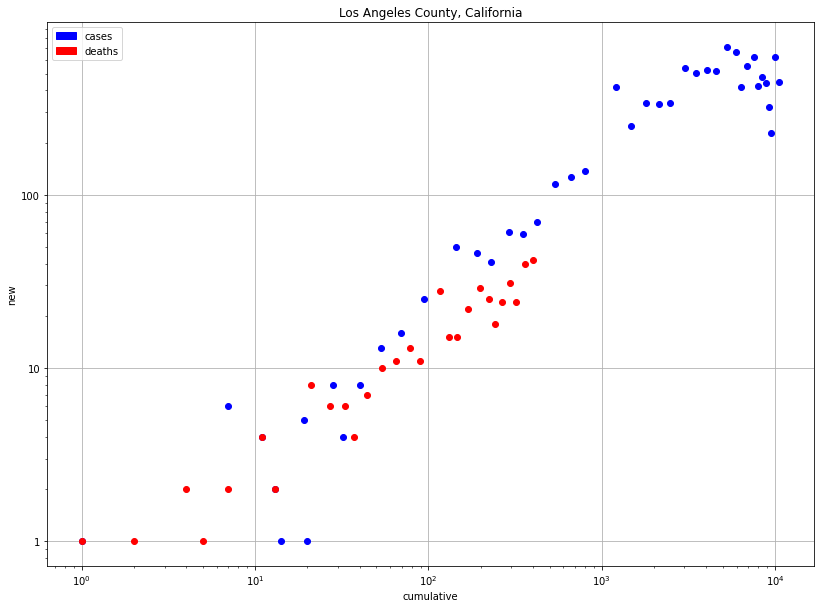

In [28]:
plot_county(data_counties, 'Los Angeles', 'California', '2020-03-19')

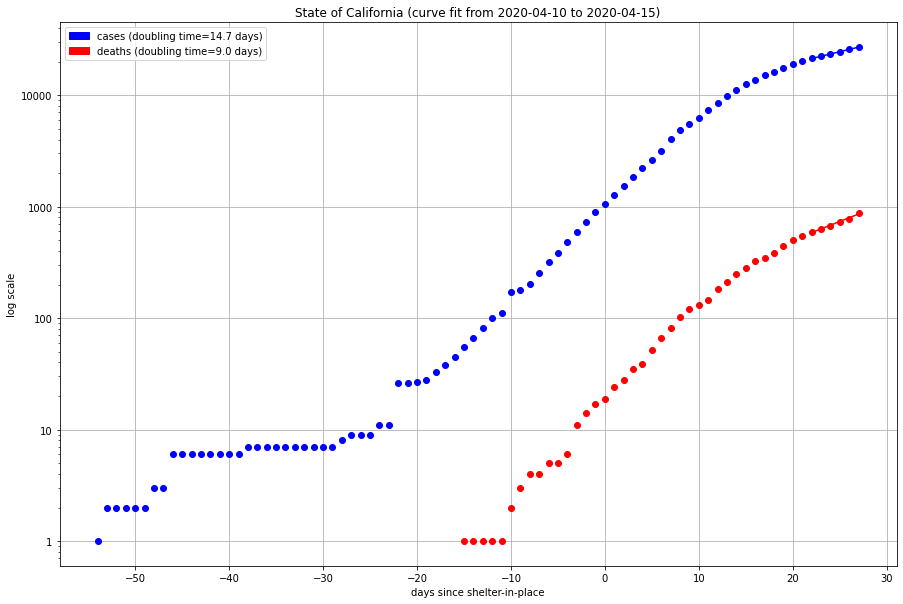

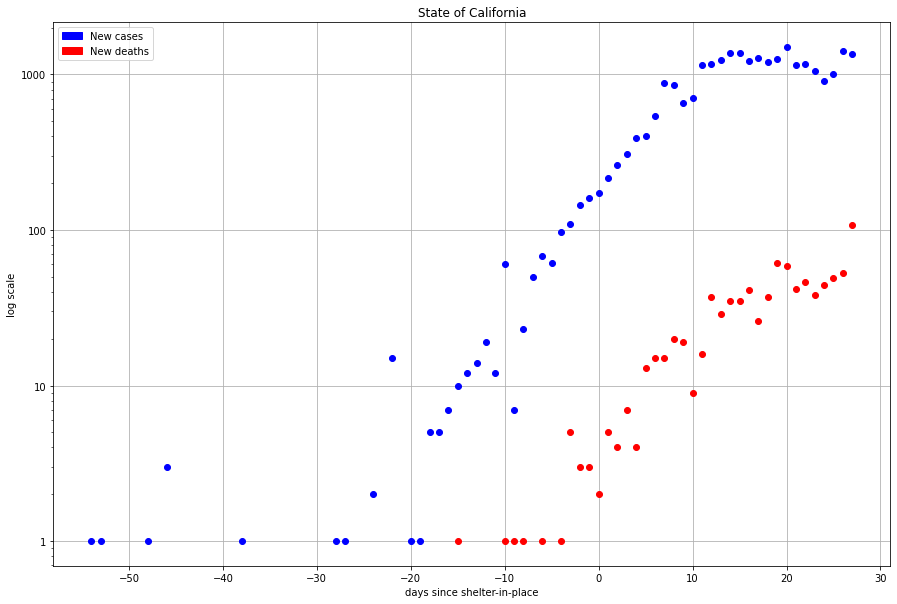

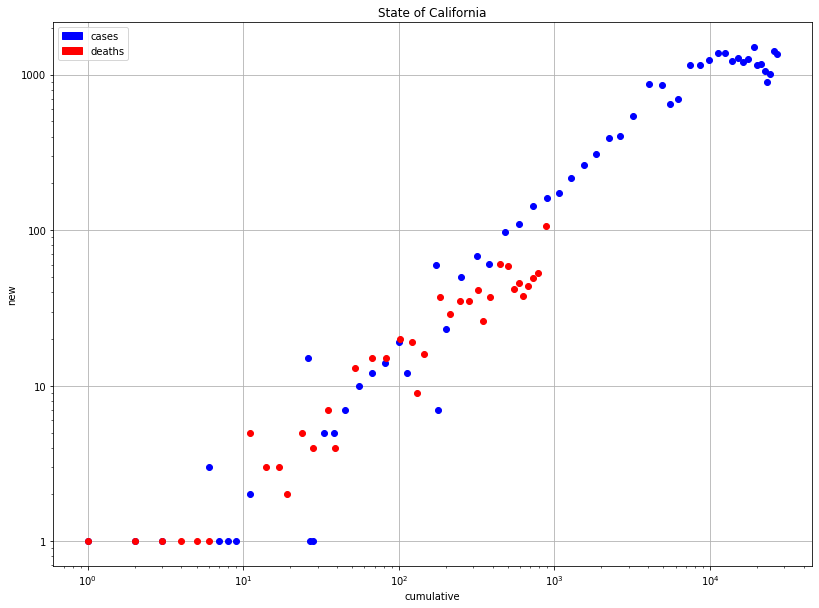

In [15]:
plot_state(data_states, 'California', '2020-03-19')

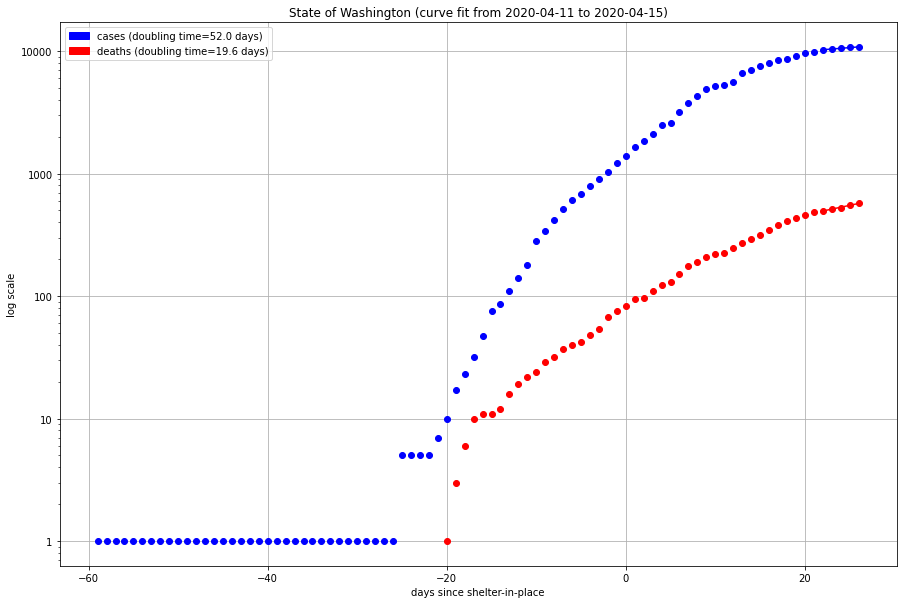

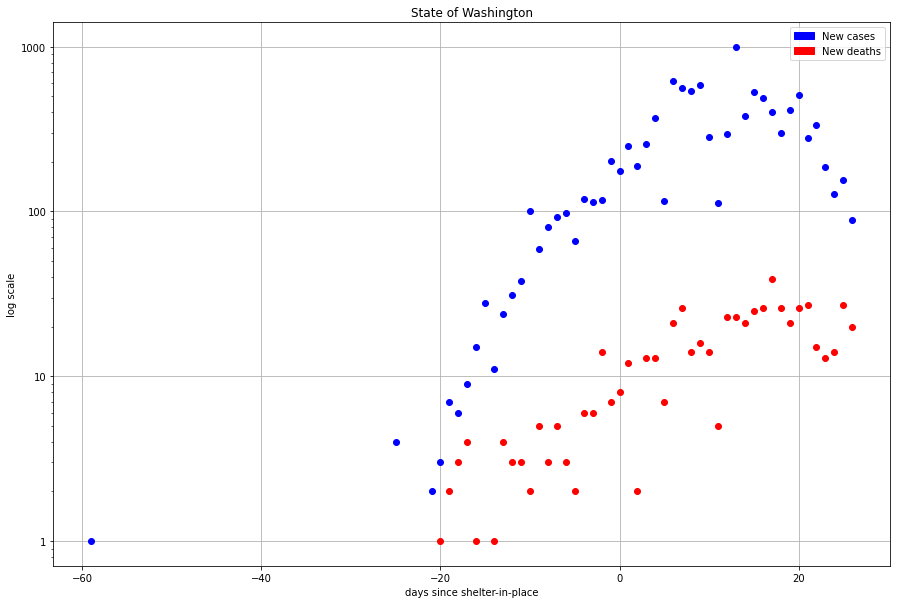

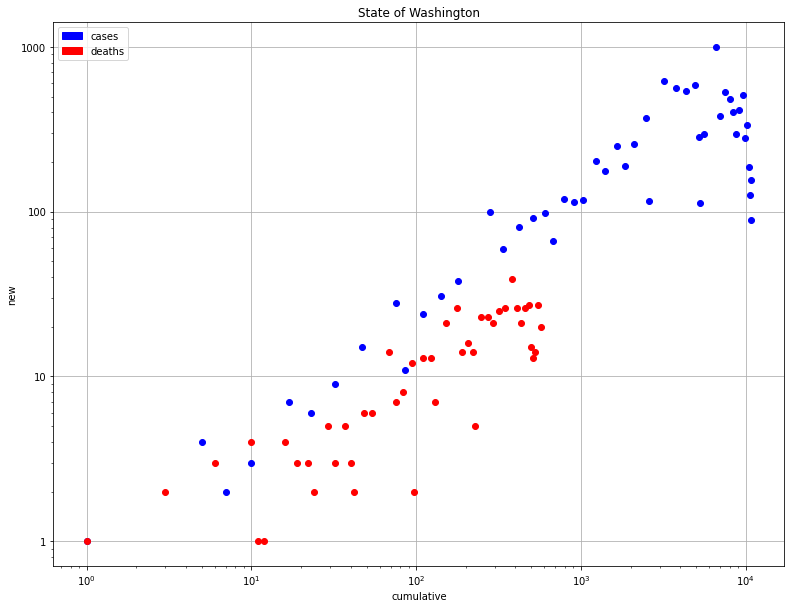

In [29]:
plot_state(data_states, 'Washington', '2020-03-20')

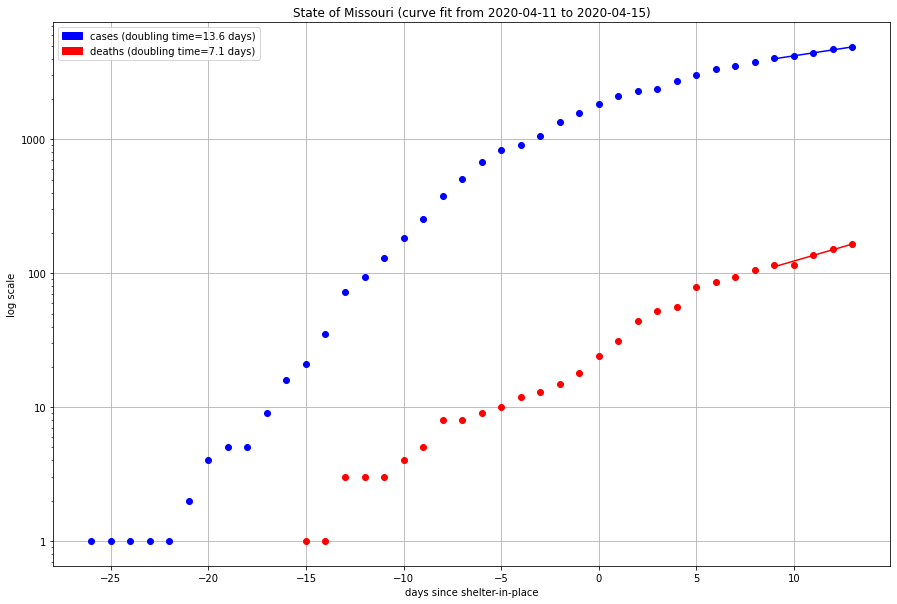

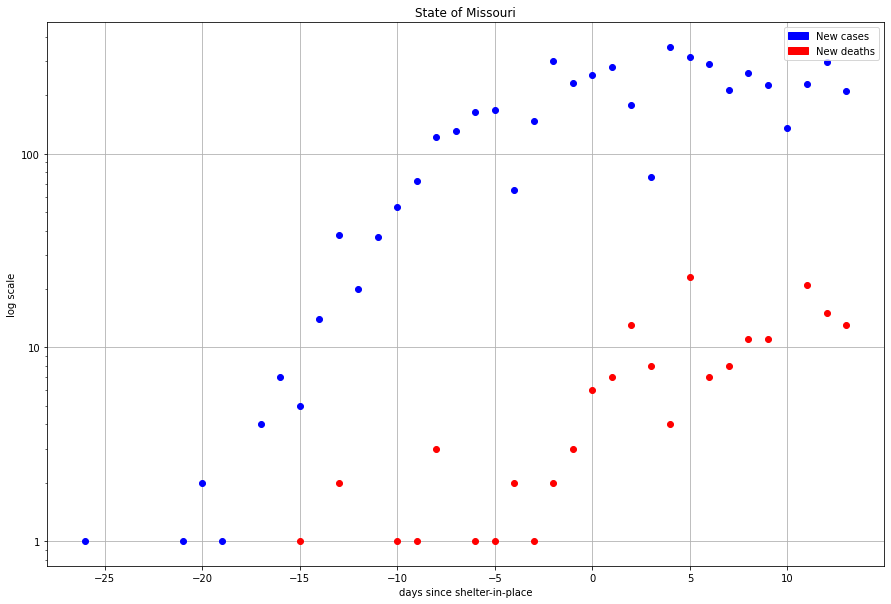

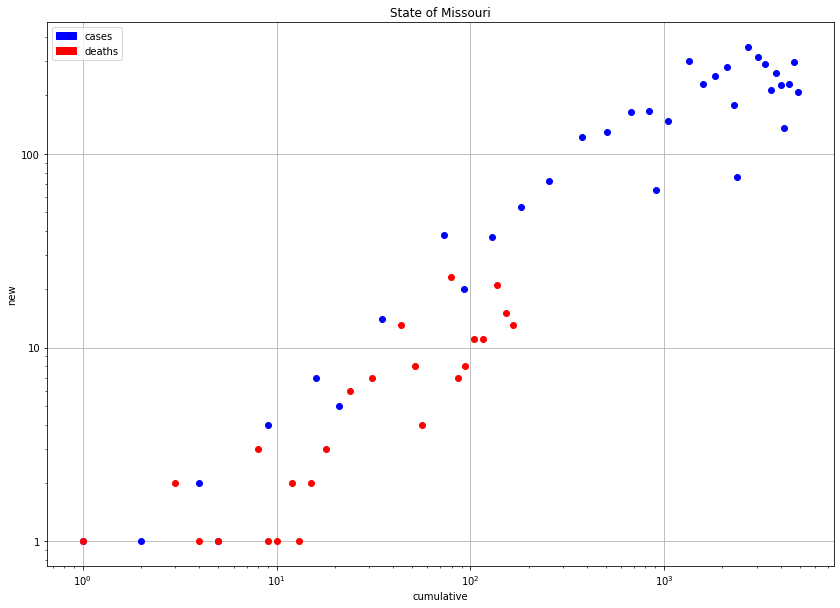

In [30]:
plot_state(data_states, 'Missouri', '2020-04-02')